# Logistic Regression (Binary & Multinomial)

**Scenario**: Lead qualification, predict whether a marketing lead will convert.

Use a chronological split, evaluate ROC/PR, pick an operating threshold, and calibrate probabilities.

Show multinomial logistic for lead **priority** (low/medium/high).

Log loss: 0.6048614068795803
AUC-ROC: 0.594  |  AP (PR AUC): 0.386
Confusion matrix @ threshold 0.5 :
 [[3423   43]
 [1498   36]]

Report:
               precision    recall  f1-score   support

           0      0.696     0.988     0.816      3466
           1      0.456     0.023     0.045      1534

    accuracy                          0.692      5000
   macro avg      0.576     0.506     0.430      5000
weighted avg      0.622     0.692     0.580      5000



/Users/jihunmoon/PythonProjects/Git/ust-mail/.venv/lib/python3.12/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/jihunmoon/PythonProjects/Git/ust-mail/.venv/lib/python3.12/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/jihunmoon/PythonProjects/Git/ust-mail/.venv/lib/python3.12/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/jihunmoon/PythonProjects/Git/ust-mail/.venv/lib/python3.12/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: divide by zero encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights
/Users/jihunmoon/PythonProjects/Git/ust-mail/.venv/lib/python3.12/site-packages/sklearn/linear_model/_linea

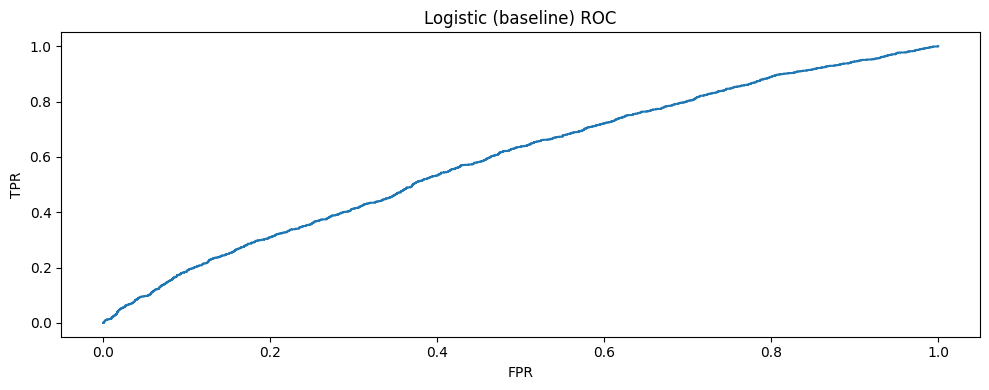

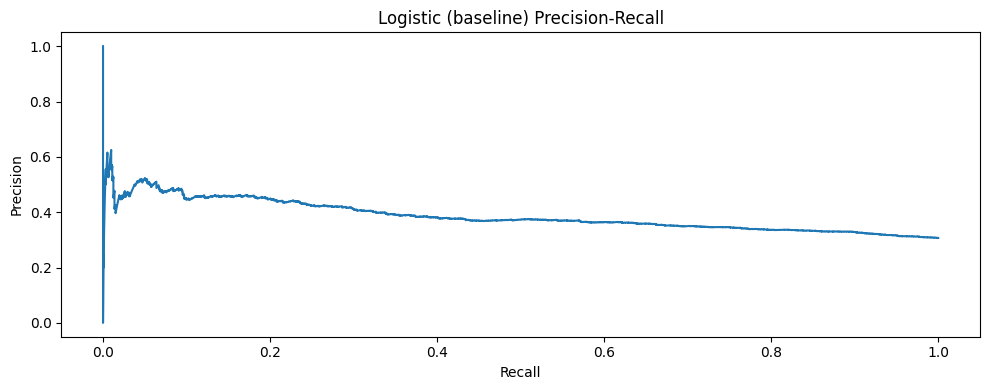

In [ ]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split

!wget -q https://raw.githubusercontent.com/Jihun-ust/ust-mail-557/main/Classification/classification_utils.py
import classification_utils as utils
csv_path = "https://raw.githubusercontent.com/Jihun-ust/ust-mail-557/main/Regression_Forecasting/marketing_daily.csv"

df = pd.read_csv(csv_path, parse_dates=["ts"]).sort_values("ts")
train, test = utils.chrono_split(df, "ts", test_frac=0.2)

features = ["ad_channel","device","region","campaign","spend_l7","pages_per_session","sessions_l30","time_on_site_s","pricing_views_l7","email_opens_l30","past_purchases","tenure_days","discount_flag","competitor_visits"]
target = "converted"

X_train, y_train = train[features], train[target]
X_test, y_test = test[features], test[target]

pre = ColumnTransformer([
    ("num", StandardScaler(), ["spend_l7","pages_per_session","sessions_l30","time_on_site_s","pricing_views_l7","email_opens_l30","past_purchases","tenure_days"]),
    ("cat", OneHotEncoder(handle_unknown="ignore"), ["ad_channel","device","region","campaign"]),
    ("bin", "passthrough", ["discount_flag","competitor_visits"])
])

clf = Pipeline([("pre", pre), ("lr", LogisticRegression(max_iter=500, class_weight=None))])
clf.fit(X_train, y_train)
probs = clf.predict_proba(X_test)[:,1]
print("Log loss:", log_loss(y_test, probs))
metrics = utils.evaluate_classifier(y_test, probs, threshold=0.5, title_prefix="Logistic (baseline)")

## Pick an operating threshold based on F1 (or cost)

Best threshold (F1-like): 0.24
AUC-ROC: 0.594  |  AP (PR AUC): 0.386
Confusion matrix @ threshold 0.24000000000000002 :
 [[ 674 2792]
 [ 161 1373]]

Report:
               precision    recall  f1-score   support

           0      0.807     0.194     0.313      3466
           1      0.330     0.895     0.482      1534

    accuracy                          0.409      5000
   macro avg      0.568     0.545     0.398      5000
weighted avg      0.661     0.409     0.365      5000



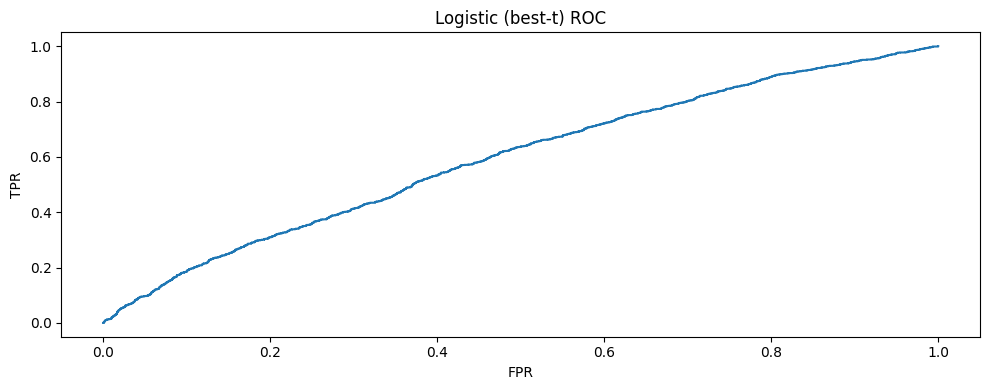

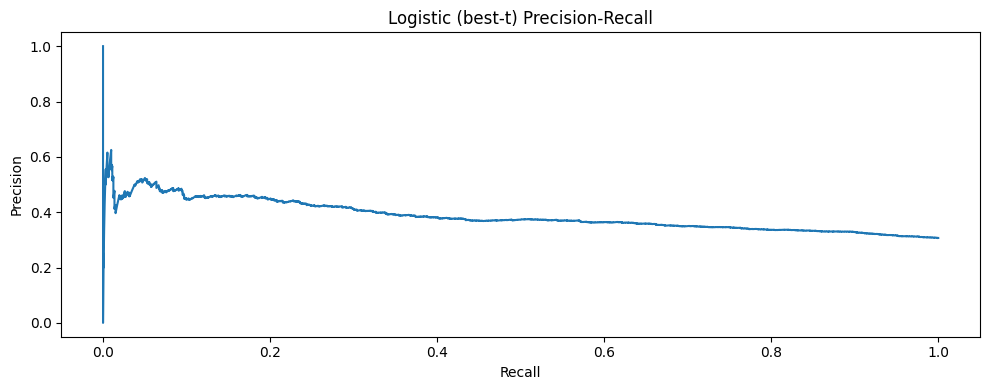

In [ ]:
best_t, best_s = utils.search_threshold(y_test, probs)
print("Best threshold (F1-like):", round(best_t, 3))
_ = utils.evaluate_classifier(y_test, probs, threshold=best_t, title_prefix="Logistic (best-t)")

## Calibration (optional)

Brier (uncal): 0.207689046389738  | Brier (cal): 0.20887899751148944
AUC-ROC: 0.593  |  AP (PR AUC): 0.378
Confusion matrix @ threshold 0.24000000000000002 :
 [[ 113 3353]
 [  30 1504]]

Report:
               precision    recall  f1-score   support

           0      0.790     0.033     0.063      3466
           1      0.310     0.980     0.471      1534

    accuracy                          0.323      5000
   macro avg      0.550     0.507     0.267      5000
weighted avg      0.643     0.323     0.188      5000



/Users/jihunmoon/PythonProjects/Git/ust-mail/.venv/lib/python3.12/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/jihunmoon/PythonProjects/Git/ust-mail/.venv/lib/python3.12/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/jihunmoon/PythonProjects/Git/ust-mail/.venv/lib/python3.12/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/jihunmoon/PythonProjects/Git/ust-mail/.venv/lib/python3.12/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: divide by zero encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights
/Users/jihunmoon/PythonProjects/Git/ust-mail/.venv/lib/python3.12/site-packages/sklearn/linear_model/_linea

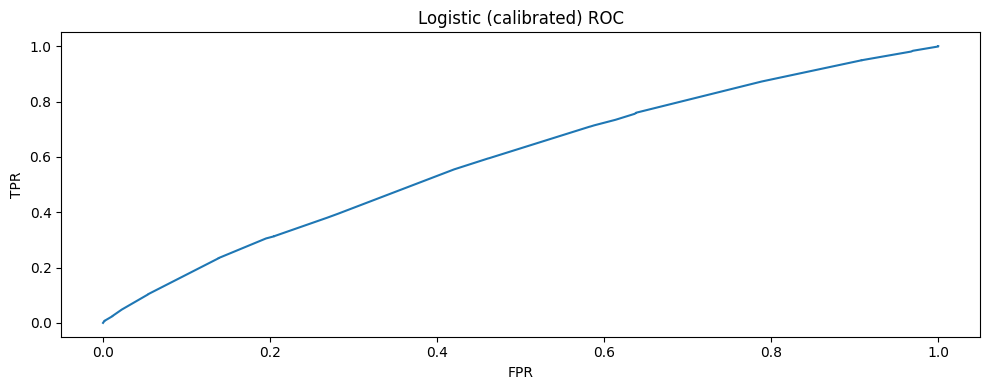

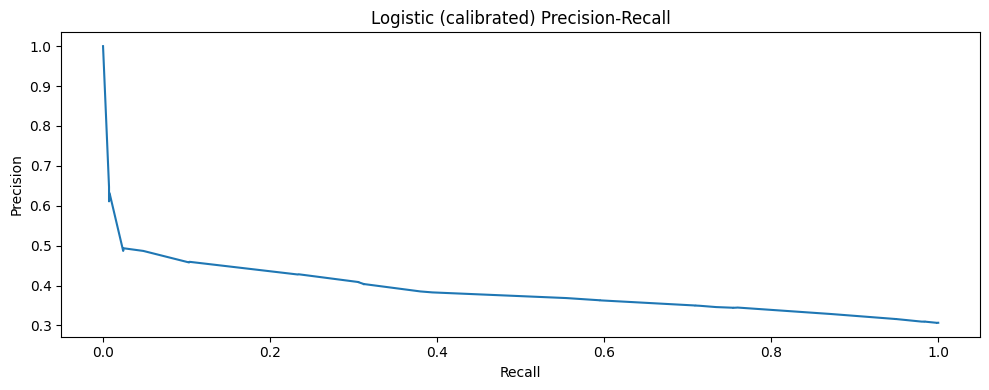

In [ ]:
# Split a validation set from train for calibration demo
subtrain, val = train.iloc[:-5000], train.iloc[-5000:]
X_sub, y_sub = subtrain[features], subtrain[target]
X_val, y_val = val[features], val[target]
clf.fit(X_sub, y_sub)
cal = utils.calibrate_probabilities(clf, X_val, y_val, method="isotonic")  # using pre-fit transform
# For simplicity, refit a pipeline wrapper by predicting on transformed X_test:
X_test_trans = X_test
probs_cal = cal.predict_proba(X_test_trans)[:,1]
print("Brier (uncal):", utils.brier_score_loss(y_test, probs), " | Brier (cal):", utils.brier_score_loss(y_test, probs_cal))
_ = utils.evaluate_classifier(y_test, probs_cal, threshold=best_t, title_prefix="Logistic (calibrated)")

## Multinomial logistic (lead priority: low/medium/high)

In [11]:
from sklearn.linear_model import LogisticRegression
y_multi = train["priority"]
X_multi = train[features]
pre2 = pre
multi = Pipeline([("pre", pre2), ("lr", LogisticRegression(max_iter=600, multi_class="multinomial"))])
multi.fit(X_multi, y_multi)
print("Multinomial classes:", multi.named_steps["lr"].classes_[:])

Multinomial classes: ['high' 'low' 'medium']


/Users/jihunmoon/PythonProjects/Git/ust-mail/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/jihunmoon/PythonProjects/Git/ust-mail/.venv/lib/python3.12/site-packages/sklearn/linear_model/_linear_loss.py:203: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights.T + intercept  # ndarray, likely C-contiguous
/Users/jihunmoon/PythonProjects/Git/ust-mail/.venv/lib/python3.12/site-packages/sklearn/linear_model/_linear_loss.py:203: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights.T + intercept  # ndarray, likely C-contiguous
/Users/jihunmoon/PythonProjects/Git/ust-mail/.venv/lib/python3.12/site-packages/sklearn/linear_model/_linear_loss.py:203: RuntimeWarning: invalid value encountered in matmul
  r